### Problem Set 1

#### Fatykhoph Denis, MSc
#### 2024 Moscow

### Task 1: Configuration Space (40 points)

In [9]:
from utils import *
import numpy as np
from scipy.signal import convolve2d
from queue import PriorityQueue
from dataclasses import dataclass


##### **A (10 pts)** Visualize from the given data the workspace and the different rod configurations for each discretized orientation. Comment on the given discretized values for orientation

In [10]:
img = np.load('data_ps1.npz')
env = img['environment']
rod = img['rod']

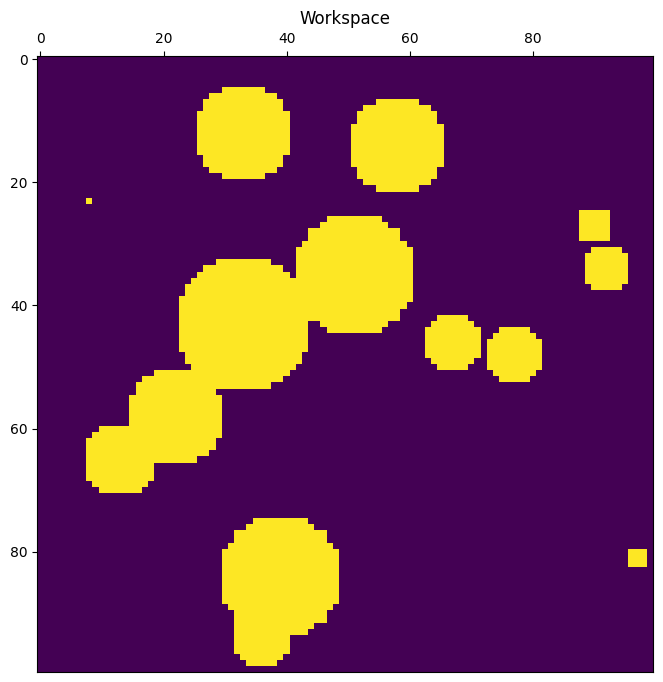

In [11]:
plt.figure(figsize=(8, 8))
plt.title("Workspace")

plt.imshow(env, origin='upper')

ax = plt.gca()

# Move x-axis ticks and labels to the top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.show()

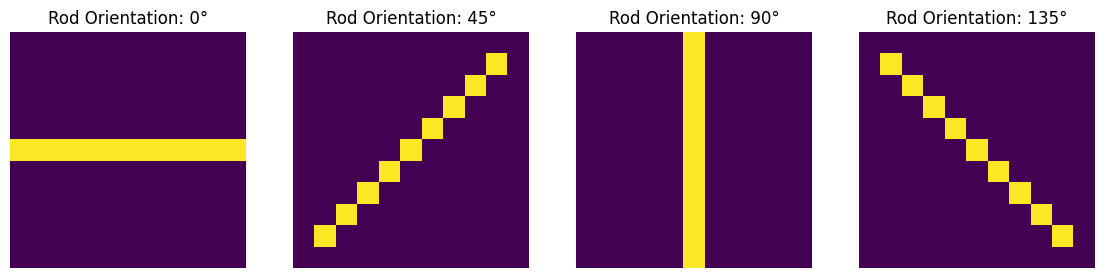

In [12]:
orientations = ["0°", "45°", "90°", "135°"]
fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for i in range(4):
    axs[i].imshow(rod[:, :, i])
    axs[i].set_title(f"Rod Orientation: {orientations[i]}")
    axs[i].axis('off')
plt.show()

The robot’s orientation is limited to four discrete angles: 0°, 45°, 90°, and 135°. While this restricts the range of angles the robot can assume, it makes the calculations more efficient. Allowing the robot to rotate by every degree, for instance, would greatly expand the size and complexity of the C-space, making computations significantly more challenging.

##### **B (10 pts)** Visualize the environment together with the object. For this, you may want to use the function **plot_joint_environment** from **utils.py** and select any valid configuration value for the rod.

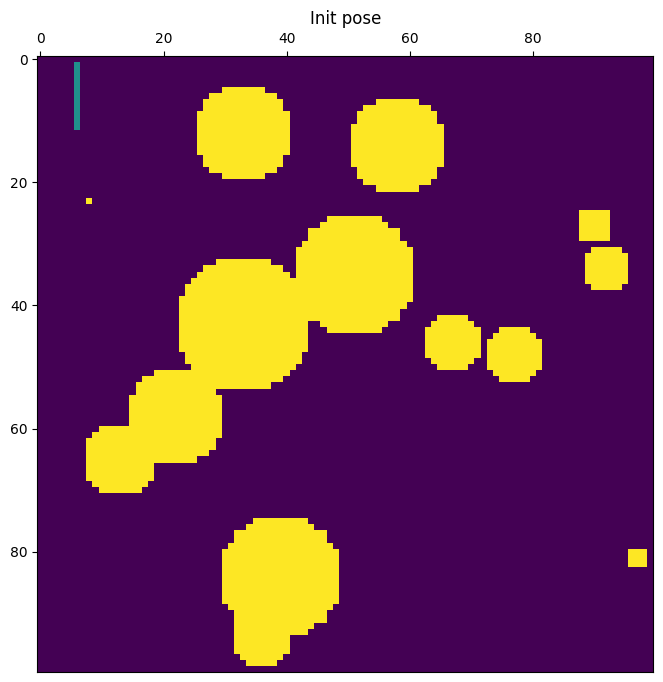

In [13]:
plt.figure(figsize=(8, 8))
plt.title("Init pose")

plt.imshow(plot_enviroment(img=env,obj=rod,state=(6,6,2)), origin='upper')
ax = plt.gca()

# Move x-axis ticks and labels to the top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

##### **C (10 pts)** Create the C-space for the 2D environment map. For this, plot all the images corresponding to each of the orientations by using collision checking.

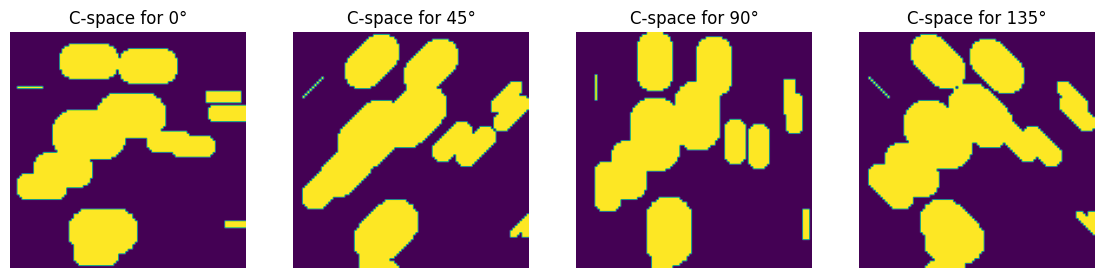

In [14]:
c_space = np.array([normalize_image(convolve2d(in1=env,in2=rod[:, :, i],boundary='symm', mode='same')) for i in range(4)])
orientations = ["0°", "45°", "90°", "135°"]
fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for i in range(c_space.shape[0]):
    axs[i].imshow(c_space[i])
    axs[i].set_title(f"C-space for {orientations[i]}")
    axs[i].axis('off')
plt.show()

##### **D (10 pts)** Comment on the obtained C-space with the previous method. What is the size of the C-space?

The C-space for each robot orientation (consisting of four layers for 0°, 45°, 90°, and 135°) has dimensions of 4 $ \times $ 100 $ \times $ 100. It represents the positions the robot can occupy while avoiding obstacles.

To construct this space, a convolution is performed using a kernel that matches the shape of the robot to identify obstacles for each orientation at each point on the map.

This C-space is then used by the pathfinding algorithm.

### Task 2: A star Algorithm (60 points)
**A (40 pts)** You need to implement the A star algorithm and plan in the generated discrete C-space from the previous task. The starting configuration of the agent is $(6,6,2)$ and the goal configuration is $(72,64,0)$. On this first iteration, use an heuristic function $h(q,q_G) = 0$, which is equivalent to the Dijkstra algorithm.

Save the result of calculated plan in **rod_solve.mp4** using **plotting_result(environment,rod,plan)** from **utils.py**, where plan is list of rod states from start to goal.

**hint**: Track the number of visited states to avoid/debug potential issues with internal loops

In [15]:
def a_star(
        init_state: np.ndarray,
        goal_state: np.ndarray,
        workspace_map: np.ndarray,
        useHeuristic=False,
        useAngle=False
        ):

    layer_count = workspace_map.shape[0]
    cartesian_cost = 1
    rotation_cost = 1

    def compute_weight(pos1, pos2):
        if useAngle:
            theta_diff = abs(pos1[2] - pos2[2]) % layer_count
            return np.linalg.norm(pos1[:2] - pos2[:2]) \
                            + min(theta_diff, layer_count - theta_diff)
        elif useHeuristic:
            return abs(int(pos1[0]) - int(pos2[0])) \
                + abs(int(pos1[1]) - int(pos2[1]))
        return 0

    def next_states(active_position, current_cost):
        transitions = np.array([
            [1, 0, 0, cartesian_cost],
            [-1, 0, 0, cartesian_cost],
            [0, 1, 0, cartesian_cost],
            [0, -1, 0, cartesian_cost],
            [0, 0, 1, rotation_cost],
            [0, 0, -1, rotation_cost]
        ])
        
        future_transitions = []
        for transition in transitions:
            next_position = active_position + transition[:3]
            move_cost = transition[3]
            next_position[2] %= layer_count
            
            pos_x = int(next_position[0])
            pos_y = int(next_position[1])
            theta = int(next_position[2])
            
            obj_width = int((rod.shape[0] - 1) / 2)
            obj_height = int((rod.shape[1] - 1) / 2)
            
            y_lower = pos_y - obj_width
            y_upper = pos_y + obj_width + 1
            x_lower = pos_x - obj_height
            x_upper = pos_x + obj_height + 1
            
            # Validate that current state localized in the map
            if y_lower < 0 or x_lower < 0 or y_upper > workspace_map.shape[1] or x_upper > workspace_map.shape[2]:
                continue 
            
            if workspace_map[theta, pos_x, pos_y] == 0:
                future_transitions.append((next_position, move_cost))
        return future_transitions

    queue = PriorityQueue()
    init_pose_tuple = tuple(map(int, init_state))
    queue.put((compute_weight(init_state, goal_state), init_pose_tuple)) 
    
    origin_path = {}
    total_cost = {init_pose_tuple: 0}
    
    visited_nodes = set()
    explored_count = 0

    while not queue.empty():
        _, active_position_tuple = queue.get()
        active_position = np.array(active_position_tuple)

        if active_position_tuple in visited_nodes:
            continue
        visited_nodes.add(active_position_tuple)
        explored_count += 1
        if np.array_equal(active_position, goal_state):
            path_trace = []
            while active_position_tuple in origin_path:
                path_trace.append(active_position)
                active_position_tuple = origin_path[active_position_tuple]
                active_position = np.array(active_position_tuple)
            path_trace.append(init_state)
            print("Path found")
            final_cost = total_cost[tuple(map(int, goal_state))]
            print(f"Path cost: {final_cost}")
            print(f"Number of explored nodes: {explored_count}")
            reverse_path = [tuple(map(int, state)) for state in path_trace[::-1]]
            return reverse_path 

        for next_position, move_cost in next_states(active_position, total_cost[active_position_tuple]):
            next_position_tuple = tuple(map(int, next_position))
            
            temp_cost = total_cost[active_position_tuple] + move_cost
            
            if next_position_tuple not in total_cost or (temp_cost < total_cost[next_position_tuple]):
                origin_path[next_position_tuple] = active_position_tuple
                total_cost[next_position_tuple] = temp_cost
                estimated_cost = temp_cost + compute_weight(next_position, goal_state)
                
                queue.put((estimated_cost, next_position_tuple))

    print("No viable path")
    return None


In this case, we do not employ a compute_weight, which causes our algorithm to function similarly to Dijkstra's algorithm. As a result, we explore significantly more nodes compared to the $ A^* $ algorithm.

Path found
Path cost: 126
Number of explored nodes: 14331
Length of the path: 127


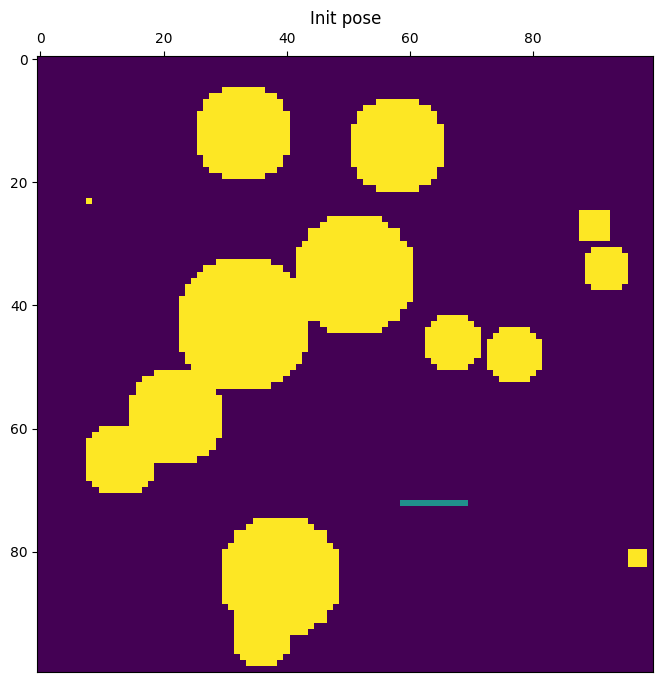

In [16]:
init_state = np.array([6, 6, 2])  
goal_state = np.array([72, 64, 0])   
path = a_star(init_state, goal_state, c_space,useHeuristic=False)
print(f"Length of the path: {len(path)}")
plotting_results(environment=env, rod=rod, plan=path, save_path='rod_solve_Dj.mp4')

Then, we've used a compute_weight, as a result a amount of explored decreases.

Path found
Path cost: 126
Number of explored nodes: 4037
Length of the path: 127


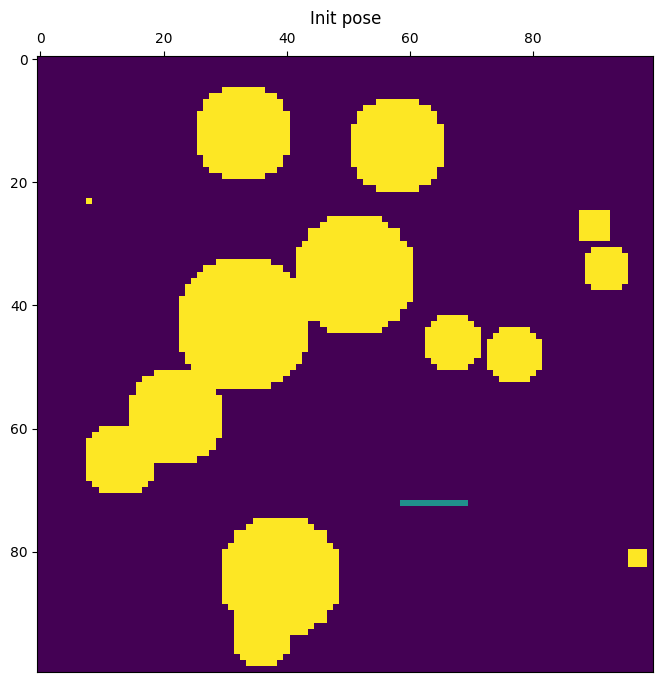

In [17]:
init_state = np.array([6, 6, 2])  
goal_state = np.array([72, 64, 0])   
path = a_star(init_state, goal_state, c_space,useHeuristic=True)
print(f"Length of the path: {len(path)}")
plotting_results(environment=env, rod=rod, plan=path, save_path='rod_solve_A.mp4')

Here, we use a combined compute_weight:

1. The Manhattan distance calculates the path in horizontal and vertical directions, which is efficient in a discrete grid.
2. The angle component determines the minimum number of turns needed to achieve the desired orientation layer. This is particularly useful when turns are more 'costly' than displacements.

This approach enables the $ A^* $ algorithm to not only find a path with the fewest displacements but also minimize the number of turns, leading to a faster and more efficient path search compared to Dijkstra's algorithm.

Path found
Path cost: 126
Number of explored nodes: 4520
Length of the path: 127


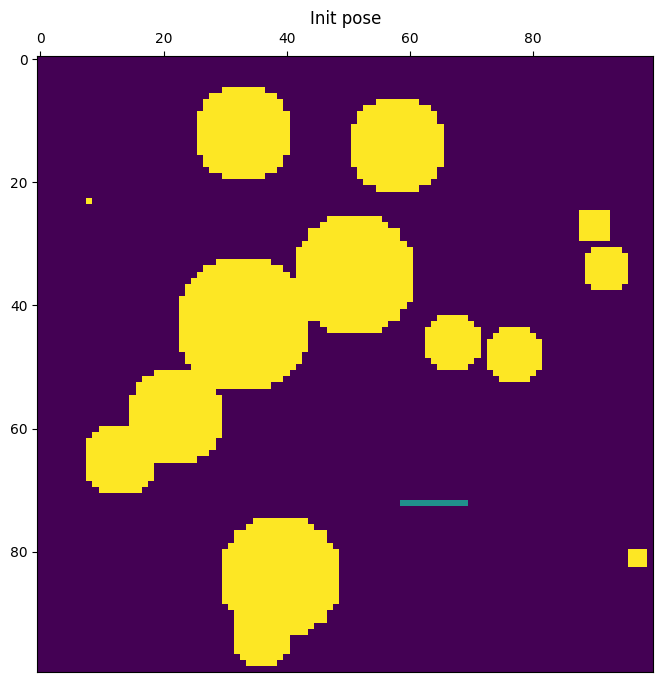

In [18]:
init_state = np.array([6, 6, 2])  
goal_state = np.array([72, 64, 0])   
path = a_star(init_state, goal_state, c_space,useAngle=True)
print(f"Length of the path: {len(path)}")
plotting_results(environment=env, rod=rod, plan=path, save_path='rod_sole_angle.mp4')